In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
df_train = pd.read_csv('../assets/df_train_full_info.csv')
df_dev = pd.read_csv('../assets/df_dev_full_info.csv')
df_test = pd.read_csv('../assets/df_test_full_info.csv')
df = pd.concat([df_train,df_dev,df_test])
# Network analysis requires strongly on the twitter information scraped from the API. 
# Therefore we eliminate all those tweets which we did not scrape successfully right in the first step.
df = df[df['Response-Code']=='Successful']

In [4]:
df_harvey = df[df['place'].str.startswith('harvey')]

In [29]:
df_harvey['user_mentions']=df_harvey['entities'].map(lambda x:eval(x)['user_mentions'])
df_harvey['user_screen_name'] = df_harvey['user'].map(lambda x:eval(x)['screen_name'])
df_harvey_user_mention=df_harvey[df_harvey['user_mentions'].str.len()>0]
df_harvey_user_mention['user_mentions_screen_name'] = df_harvey_user_mention['user_mentions'].map(lambda x:[i['screen_name'] for i in x])

<ipython-input-29-b458d3c41ba1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_harvey['user_mentions']=df_harvey['entities'].map(lambda x:eval(x)['user_mentions'])
<ipython-input-29-b458d3c41ba1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_harvey['user_screen_name'] = df_harvey['user'].map(lambda x:eval(x)['screen_name'])
<ipython-input-29-b458d3c41ba1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Assumptions: 

1. All relationships are mutual and weighted (i.e. weighted and directed graph). It's not the best model, but it's what we can do with few data;
2. If User A mentions User B, then there is a mutual relationship between A and B;
3. If User A mentions both User B and User C, then there is an additional mutual relationship between B and C;
4. If there have been $n$ interactions between users A and B, then their mutual weight is set to $n$.

In [40]:
G = nx.Graph()
list_edge = dict()

for idx in range(df_harvey_user_mention.shape[0]):
    user1 = df_harvey_user_mention.iloc[idx]['user_screen_name']
    user2_list = df_harvey_user_mention.iloc[idx]['user_mentions_screen_name']
    for user2 in user2_list:
        if (user1,user2) in list_edge:
            list_edge[(user1,user2)]+=1
        elif (user2,user1) in list_edge:
            list_edge[(user2,user1)]+=1
        else:
            list_edge[(user1,user2)]=1
        
    if len(user2_list)>1:
        for i in range(len(user2_list)-1):
            for j in range(i,len(user2_list)):
                if (user2_list[i],user2_list[j]) in list_edge:
                    list_edge[(user2_list[i],user2_list[j])]+=1
                elif (user2_list[j],user2_list[i]) in list_edge:
                    list_edge[(user2_list[j],user2_list[i])]+=1
                else:
                    list_edge[(user2_list[i],user2_list[j])]=1
    
G.add_weighted_edges_from([i+(list_edge[i],) for i in list_edge]) 

In [41]:
G.number_of_nodes()

5822

In [42]:
G.number_of_edges()

6254

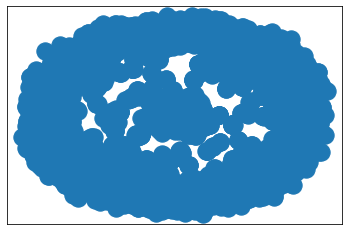

In [45]:
nx.draw_networkx(G,with_labels=False)